In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM, BatchNormalization
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [2]:
currency_name = 'USDJPY'

In [3]:
df = pd.read_parquet('../Dataframes/df_' + currency_name + '.parquet.gzip')

In [4]:
df.head()

,date,open,high,low,close,delta,wclose,so_3,so_4,so_5,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,109.28,109.80,108.65,108.91,0.0,109.0675,39.455782,39.455782,65.900383,...,109.545,108.490,109.0175,109.225,2.375297,3.280203,3.908003,3.610062,-2.832721,-3.590073
30,14/2/2000,108.91,109.07,108.05,108.95,1.0,108.7550,51.428571,51.428571,51.428571,...,109.435,108.350,108.8925,108.560,2.311719,3.280203,4.136691,3.908023,-2.916397,-3.588241
31,15/2/2000,108.95,109.34,108.47,109.23,1.0,109.0675,67.428571,67.428571,67.428571,...,109.205,108.260,108.7325,108.905,-2.699663,-0.187172,1.124101,3.998308,-2.877427,-3.669807
32,16/2/2000,109.23,109.66,108.89,109.43,1.0,109.3525,85.714286,78.857143,78.857143,...,109.500,108.680,109.0900,109.275,-2.152215,-2.625438,-1.987459,3.332893,-2.960235,-3.722334
33,17/2/2000,109.43,110.69,109.32,110.55,1.0,110.2775,93.693694,94.696970,94.696970,...,110.175,109.105,109.6400,110.005,-2.373775,-2.202729,-2.501805,0.991664,-3.432619,-3.744064


In [5]:
# swap high price and opening price

# now the second column is now daily high price

def swap_columns(df, c1, c2):
    df['temp'] = df[c1]
    df[c1] = df[c2]
    df[c2] = df['temp']
    df.drop(columns=['temp'], inplace=True)
    df.rename(columns={c1: c2, c2: c1}, inplace=True)
    
swap_columns(df, 'open', 'high')

In [6]:
df.drop(columns=['delta'],inplace=True)

In [7]:
df.head()

,date,high,open,low,close,wclose,so_3,so_4,so_5,so_8,...,hi_avg_2,lo_avg_2,hilo_avg_2,hilo_avg,slope_3,slope_4,slope_5,slope_10,slope_20,slope_30
29,11/2/2000,109.80,109.28,108.65,108.91,109.0675,39.455782,39.455782,65.900383,66.791045,...,109.545,108.490,109.0175,109.225,2.375297,3.280203,3.908003,3.610062,-2.832721,-3.590073
30,14/2/2000,109.07,108.91,108.05,108.95,108.7550,51.428571,51.428571,51.428571,68.283582,...,109.435,108.350,108.8925,108.560,2.311719,3.280203,4.136691,3.908023,-2.916397,-3.588241
31,15/2/2000,109.34,108.95,108.47,109.23,109.0675,67.428571,67.428571,67.428571,78.731343,...,109.205,108.260,108.7325,108.905,-2.699663,-0.187172,1.124101,3.998308,-2.877427,-3.669807
32,16/2/2000,109.66,109.23,108.89,109.43,109.3525,85.714286,78.857143,78.857143,85.823755,...,109.500,108.680,109.0900,109.275,-2.152215,-2.625438,-1.987459,3.332893,-2.960235,-3.722334
33,17/2/2000,110.69,109.43,109.32,110.55,110.2775,93.693694,94.696970,94.696970,94.696970,...,110.175,109.105,109.6400,110.005,-2.373775,-2.202729,-2.501805,0.991664,-3.432619,-3.744064


### Change the normalization to be (0, 1)

In [8]:
data = df

# constants
lookback = 50
batch_size = 512
epoch = 10

# 30% of the data used for testing
test_size = int(.1 * (len(data)-lookback))


# feed the lstm with all features starting from the open price
# still contains the high
input_features = data.iloc[:, 1:].values
input_data = input_features

# train a numpy array of input vectors
sc = MinMaxScaler(feature_range = (0, 1))

input_data[:,:] = sc.fit_transform(input_features[:,:])

In [9]:
input_features

array([[0.57142857, 0.56769516, 0.56661562, ..., 0.55790878, 0.35755255,
        0.46995317],
       [0.55908707, 0.56145675, 0.55640633, ..., 0.56571548, 0.35548149,
        0.47000093],
       [0.56365173, 0.56213118, 0.56355283, ..., 0.56808097, 0.35644602,
        0.46787441],
       ...,
       [0.56686391, 0.56921261, 0.57699507, ..., 0.31095497, 0.49018061,
        0.67747134],
       [0.56703297, 0.56971843, 0.5783563 , ..., 0.30800751, 0.43727181,
        0.66063875],
       [0.56534235, 0.56971843, 0.57818615, ..., 0.30869693, 0.34748199,
        0.62791304]])

In [10]:
input_data.shape

(5181, 33)

In [11]:
# number of features excluding the target feature
feature_size = input_data.shape[1] - 1
feature_size

32

In [12]:
input_data

array([[0.57142857, 0.56769516, 0.56661562, ..., 0.55790878, 0.35755255,
        0.46995317],
       [0.55908707, 0.56145675, 0.55640633, ..., 0.56571548, 0.35548149,
        0.47000093],
       [0.56365173, 0.56213118, 0.56355283, ..., 0.56808097, 0.35644602,
        0.46787441],
       ...,
       [0.56686391, 0.56921261, 0.57699507, ..., 0.31095497, 0.49018061,
        0.67747134],
       [0.56703297, 0.56971843, 0.5783563 , ..., 0.30800751, 0.43727181,
        0.66063875],
       [0.56534235, 0.56971843, 0.57818615, ..., 0.30869693, 0.34748199,
        0.62791304]])

In [13]:
input_data[[0],1:]

array([[0.56769516, 0.56661562, 0.56145675, 0.5657744 , 0.49954016,
        0.4932918 , 0.63842645, 0.68193548, 0.68321943, 0.71725645,
        0.59404734, 0.59005235, 0.68193548, 0.68321943, 0.71725645,
        0.64834007, 0.64152014, 0.65097493, 0.68288262, 0.54594315,
        0.76465575, 0.68834445, 0.56658185, 0.56285739, 0.5651135 ,
        0.56864248, 0.80420296, 0.53775301, 0.49969051, 0.55790878,
        0.35755255, 0.46995317]])

In [14]:
'''
package data into packs of 50 each, starting from the oldest data
up to len(data) - test_size - lookback - 1

X is excluded from the daily high price: the target value

and convert X and y to numpy array
'''
X = []
y = []
for i in range(len(data)- lookback):
    t = []
    for j in range(lookback):
        t.append(input_data[[(i + j)], 1:])
    X.append(t)
    y.append(input_data[i + lookback, 0])

X, y = np.array(X), np.array(y)

In [15]:
X

array([[[[0.56769516, 0.56661562, 0.56145675, ..., 0.55790878,
          0.35755255, 0.46995317]],

        [[0.56145675, 0.55640633, 0.56213118, ..., 0.56571548,
          0.35548149, 0.47000093]],

        [[0.56213118, 0.56355283, 0.56685213, ..., 0.56808097,
          0.35644602, 0.46787441]],

        ...,

        [[0.48727027, 0.4886847 , 0.4909796 , ..., 0.399848  ,
          0.32252447, 0.64033398]],

        [[0.4909796 , 0.49174749, 0.49367729, ..., 0.39757967,
          0.31804934, 0.62438087]],

        [[0.49367729, 0.49634167, 0.50868319, ..., 0.39584307,
          0.31747639, 0.61004583]]],


       [[[0.56145675, 0.55640633, 0.56213118, ..., 0.56571548,
          0.35548149, 0.47000093]],

        [[0.56213118, 0.56355283, 0.56685213, ..., 0.56808097,
          0.35644602, 0.46787441]],

        [[0.56685213, 0.57069934, 0.57022425, ..., 0.55064687,
          0.35439644, 0.46650496]],

        ...,

        [[0.4909796 , 0.49174749, 0.49367729, ..., 0.39757967,
       

In [16]:
# test data taken from the latest (size - (test_size + lookback)) data points
X_test = X[-test_size:]

# cut the test data out
X = X[:-(test_size)]
y = y[:-(test_size)]

# reshape
X = X.reshape(X.shape[0], lookback, feature_size)
X_test = X_test.reshape(X_test.shape[0],lookback, feature_size)
X.shape

(4618, 50, 32)

In [17]:
file = "./Models/" + currency_name + ".model"
model = None
if os.path.exists(file):
    model = load_model(file)
else:
    model = Sequential()
    model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],feature_size)))
    model.add(LSTM(units=30, return_sequences=True))
    model.add(LSTM(units=30))
    model.add(Dense(units=1))
    model.summary()
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X, y, epochs=5, batch_size=32)
    model.save(file)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 30)            7560      
_________________________________________________________________
lstm_2 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total params: 22,231
Trainable params: 22,231
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
4618/4618 [==============================] - 10s 2ms/step - loss: 0.0208
Epoch 2/5
4618/4618 [==============================] - 9s 2ms/step - loss: 6.0864e-04
Epoch 3/5
4618/4618 [==============================] - 9s 2ms/step - loss: 3.98

In [18]:
# put the predicted target value inside input_data

# inverse tranform the predicted data

predicted_value = model.predict(X_test)
li = input_data.shape[0]
lp = predicted_value.shape[0]
for i in range(li - lp, li - 1):
    input_data[i + 1][0] = predicted_value[i - (li - lp)][0]

input_data = sc.inverse_transform(input_data)

input_data = input_data[-(test_size) + 1:,0]

In [19]:
actual_data = data.iloc[:, 1:].values[-(test_size) + 1:,0]
actual_data

array([113.39, 113.18, 112.79, 111.88, 111.69, 111.19, 110.98, 111.35,
       111.48, 111.13, 111.22, 111.18, 110.34, 109.7 , 109.77, 109.2 ,
       109.2 , 109.45, 109.75, 110.48, 110.29, 109.65, 109.72, 109.78,
       109.31, 108.94, 108.78, 107.9 , 107.02, 106.4 , 106.73, 107.38,
       107.9 , 107.78, 107.13, 107.27, 107.68, 107.53, 107.2 , 106.29,
       106.24, 106.46, 106.22, 106.32, 107.05, 106.97, 107.29, 106.75,
       106.41, 106.38, 106.31, 106.61, 106.64, 106.09, 105.37, 105.48,
       105.9 , 107.01, 106.93, 106.54, 106.45, 106.66, 106.85, 107.49,
       107.46, 107.2 , 107.4 , 107.26, 107.43, 107.78, 107.61, 107.21,
       107.39, 107.52, 107.86, 108.75, 109.2 , 109.45, 109.47, 109.54,
       109.45, 109.89, 110.04, 109.92, 109.27, 109.4 , 109.35, 109.83,
       110.02, 109.57, 109.67, 110.45, 110.41, 110.86, 111.08, 111.4 ,
       111.19, 110.92, 110.12, 109.74, 109.83, 109.47, 109.07, 109.  ,
       109.73, 109.85, 110.  , 110.27, 110.22, 109.85, 110.12, 110.49,
      

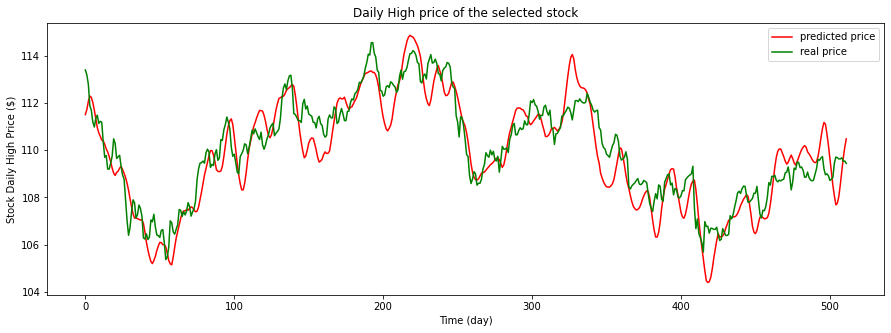

In [20]:
plt.figure(figsize=(15,5))
plt.plot(input_data, color= 'red', label="predicted price")
plt.plot(actual_data, color='green', label="real price")
plt.title("Daily High price of the selected stock")
plt.xlabel("Time (day)")
plt.ylabel("Stock Daily High Price ($)")

plt.legend()

In [21]:
# generate alphas
frame = pd.DataFrame({'actual': actual_data, 'predict': input_data})

In [22]:
frame['p1'] = frame['predict'].shift(1)
frame['diff1'] = frame['predict'] - frame['p1']
frame

,actual,predict,p1,diff1
0,113.39,111.506438,NaN,NaN
1,113.18,111.716995,111.506438,0.210557
2,112.79,112.064624,111.716995,0.347629
3,111.88,112.290362,112.064624,0.225738
4,111.69,112.226904,112.290362,-0.063458
...,...,...,...,...
507,109.63,108.542129,108.040501,0.501628
508,109.68,109.102660,108.542129,0.560530
509,109.53,109.674715,109.102660,0.572056
510,109.54,110.125684,109.674715,0.450968


In [23]:
frame['alpha'] = frame['diff1'] / frame['actual'] * 200

In [24]:
frame['wclose'] = data['wclose'].values[-(test_size) + 1:]
frame['pct_change'] = frame['wclose'].pct_change()
frame.head(10)

,actual,predict,p1,diff1,alpha,wclose,pct_change
0,113.39,111.506438,NaN,NaN,NaN,113.1125,NaN
1,113.18,111.716995,111.506438,0.210557,0.372074,112.7125,-0.003536
2,112.79,112.064624,111.716995,0.347629,0.616418,111.7350,-0.008673
3,111.88,112.290362,112.064624,0.225738,0.403536,111.3600,-0.003356
4,111.69,112.226904,112.290362,-0.063458,-0.113632,111.1775,-0.001639
5,111.19,112.015903,112.226904,-0.211001,-0.379532,110.6500,-0.004745
6,110.98,111.695753,112.015903,-0.320150,-0.576952,110.5325,-0.001062
7,111.35,111.330108,111.695753,-0.365645,-0.656749,111.0300,0.004501
8,111.48,110.956139,111.330108,-0.373969,-0.670917,111.1000,0.000630
9,111.13,110.733926,110.956139,-0.222212,-0.399914,110.7200,-0.003420


In [25]:
capital = 100000
frame['capital_allocation'] = frame['alpha'] * capital
frame['daily_pnl'] = frame['capital_allocation'] * frame['pct_change']

In [26]:
cumsum = frame['daily_pnl'].cumsum()

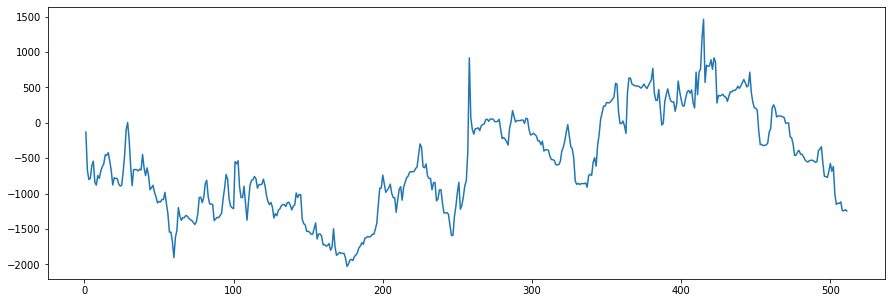

In [27]:
plt.figure(figsize=(15,5))
plt.plot(cumsum)
plt.show()

In [28]:
# calculate sharpe ratio

sharpe = np.sqrt(252) * (frame['daily_pnl'].mean()) / (frame['daily_pnl'].std())
sharpe

-0.2491958511069322

In [29]:
# calculate win/loss ratio

wins = 0
losses = 0

length = frame['daily_pnl'].count()

for i in range(length):
    if frame['daily_pnl'][i] > 0:
        wins += 1
    elif frame['daily_pnl'][i] < 0:
        losses += 1

wl = wins / losses
wl

1.069672131147541

In [30]:
# maximum drawdown
maxm = 0
drawdown = 0
cur_low = 0
size = len(cumsum)

final_start = 0
final_end = 0

start_date = 0
end_date = 0

for i in range(1, size):
    cur_val = cumsum[i]
    if cur_val >= maxm:
        
        drawdown = max(drawdown, maxm - cur_low)
        
        if drawdown == maxm - cur_low:
            final_start = start_date
            final_end = end_date
            
        maxm = cur_val
        cur_low = cur_val
        
        start_date = i
    else:
        cur_low = min(cur_low, cur_val)
        if cur_low == cur_val:
            end_date = i

print('drawdown is:', drawdown, ', from day', final_start, ', to day', final_end)

drawdown is: 2034.7243882204916 , from day 29 , to day 176
